# Data Acquisition of Polytec vibrometer


This script connects to a NI USB-6363 Data Acquisition board to generate an actuation signal, and measure the respective vibrometer data of a Polytec MSA-500 system


1. Actuation signal is generated by the DAQ
2. A copy reference of the actuation signal is acquired by the DAQ
3. The physical actuation signal is amplified and drives the device under test
4. The Polytec MSA-500 is configured using the system software, and the Detector and other configurations must be defined in this script
5. The script loop generates the actuation signal, and measures the corresponding reference and vibrometer signal
6. The acquired signal and configuration settings are stored in a json file

In [ ]:
%load_ext autoreload

%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import os

from scipy import constants as const
import nidaqmx as ni

import time
# Creating the actuation signal
from datetime import datetime
import json
from json import JSONEncoder

from scipy import signal, fft
from matplotlib import colors

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

    
    
    
# import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
from scipy import interpolate


import re


In [2]:

def progress_bar(progress, bar_length=20, bar_character='#'):
    """
    Progress bar.
    Writes a progress bar in place in the output
    
    Args:
        progress: value between 0 and 1
        bar_length: number of characters to consider in the bar
    """
    
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
#     clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( bar_character * block + "-" * (bar_length - block), progress * 100)
    if progress <1:
        end = '\r'
    else:
        end = "\n"
    print(text, end=end) 

In [3]:
def open_data_file(filename):
    # Load data from json file
    with open(filename, 'r') as fp:
        json_dict = json.load(fp)
    return json_dict
        
def load_frequency_response(filename):
    """Opens the data file and extracts frequency and amplitude"""
    data = open_data_file(filename)
    
    frequencies = np.array(data['signal_frequencies'])
    amplitude = np.array(data['vibrometer_amplitude'])
    return (frequencies, amplitude)

def load_frequency_deflection_spectrum(filename):
    """ Opens the data file, calcualtes the spectrum and returns spectrometer data"""
    data = open_data_file(filename)


    # Looping over signal and calculating FFT for each
    vibration_spectrum = []

    frequencies = np.array(data['signal_frequencies'])
    for i, frequency in enumerate(data['signal_frequencies']):
        vibrometer = data['signal'][str(i)]['vibrometer']
        ref_I = data['signal'][str(i)]['ref_I']
        time = data['signal_time']

        dt = np.diff(time[:2])
        vib_fft = fft.fft(vibrometer, )

        vibration_freqs = fft.fftfreq(vib_fft.size, d=dt)
        vib_fft = fft.fftshift(vib_fft)
        vibration_freqs = fft.fftshift(vibration_freqs)


        vibration_spectrum.append(vib_fft)
        # plt.plot(freqs,vib_fft)


    vibration_spectrum = np.array(vibration_spectrum).T

    spectrum_abs = np.abs(fft_list)
    spectrum_phase = np.angle(fft_list)
    
    return (frequencies, vibration_freqs, vibration_spectrum)


    
def load_time_signal_data_concatenated(filename):
    """ Opens the data file, reads signal data and concatenates in a single time signal"""
    data = open_data_file(filename)

    vibrometer_list = []
    ref_I_list = []
    for i, frequency in enumerate(data['signal_frequencies']):
        vibrometer = np.array(data['signal'][str(i)]['vibrometer'])
        vibrometer_list.append(vibrometer)
        ref_I = data['signal'][str(i)]['ref_I']

    vibrometer = np.array(vibrometer_list).flatten()
    
    time = np.arange(len(vibrometer))*data['daq_input_sample_interval']
    
    return (time, vibrometer)

In [4]:

    
    
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_value_frequency(freqs, signal, frequency):
    """Finds the value of signal closest to the given frequency"""
    idx = find_nearest_idx(freqs, frequency)
    value = signal[idx]
    return value

    

# Loop acquisition


# Adjust and run this loop

Assuming k=1758 for linearization
Running loop 

Progress: [####################] 100.0%
1758.0550330312892 1807.4180276777022
Calculated: 28.5V k=1807, $\omega_0$=145.3 Q=2.54
Storing files to  DAQ_outputs//FDPanel_T09_F10.1_top_actuation_28.5V.json
Complete


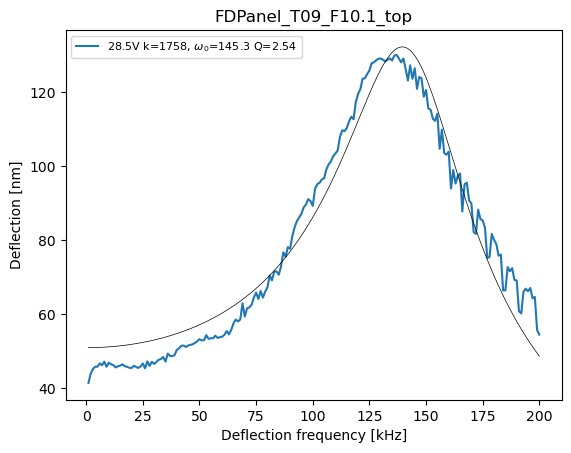

In [93]:
output_path = 'DAQ_outputs//'

LINEARIZERD = False


# frequency_list = np.array([1,2,5,10,20,50,100,120,130,140,150])*1e3
# frequency_list = np.array([1,2,])*1e3

# displacement_list = np.array([50,100])*1e-9
# displacement_list = np.array([100])*1e-9

frequency_list = np.linspace(1,200,200)*1e3
# frequency_list = np.array([1,2,5,10,20,50,100])*1e3

# select the displacement/voltage value expected at dc
max_displacement = 50*1e-9

# select the voltage amplitude to apply to the peak 
# signa takes shape of 0 to max_voltage
max_voltage = 10 #V

data_dict = dict()

data_dict['device_name'] = "FDPanel_T09_F10.1_top"

filename = data_dict['device_name']+"_actuation_%0.1fV"


data_dict['date'] = "%s"%datetime.now()


if LINEARIZED:
    data_dict['linearization_model_k'] = k
    data_dict['linearization_model_mass'] = mass
    data_dict['linearization_model_area'] = area
    data_dict['linearization_model_gap'] = gap


    print("Assuming k=%d for linearization"%(k))

# "acoustic" or "interferometer"
data_dict['measurement_type'] = "interferometer"

data_dict['interferometer_system'] = "Polytec MSA-500"
data_dict['interferometer_detector'] = 50e-9
data_dict['interferometer_detector_units'] = "m/V"
data_dict['interferometer_analog_filter_dc_block'] = True
data_dict['interferometer_analog_filter_lowpass'] = False
data_dict['actuation_amplifier_gain'] = 53
data_dict['actuation_max_displacement'] = max_displacement


if LINEARIZED:
    data_dict['actuation_max_voltage'] = linearization_function(data_dict['actuation_max_displacement'], 
                                                       gain=data_dict['actuation_amplifier_gain'], 
                                                       k=data_dict['linearization_model_k'], 
                                                       area=data_dict['linearization_model_area'], 
                                                       gap=data_dict['linearization_model_gap'])*data_dict['actuation_amplifier_gain']
else:
     data_dict['actuation_max_voltage'] = 

# DAQ sampling acquisition
data_dict['daq_system'] = "NI USB-6363"
# data_dict['input_channel_names'] = ["ref_I", "ref_Q", "vibrometer"]
# data_dict['daq_input_channels'] = ["Dev1/ai0", "Dev1/ai1", "Dev1/ai2"]

data_dict['daq_input_channels'] = ["Dev1/ai0", "Dev1/ai2"]
data_dict['daq_input_channel_names'] = ["ref_I", "vibrometer"]
data_dict['daq_input_fs'] = 500e3
data_dict['daq_input_number_of_samples'] = 2000
data_dict['daq_input_sample_rate'] = -1
data_dict['daq_input_sample_interval'] = -1

data_dict['daq_output_channels'] = ["Dev1/ao0"]
data_dict['daq_output_channel_names'] = ["V_actuation"]
data_dict['daq_output_fs'] = 2e6
data_dict['daq_output_waveform_periods'] = 10


data_dict['signal_frequencies'] = frequency_list
# acquired signal will be stored inside the 'signal' key
data_dict['signal'] = dict()

data_dict['vibrometer_amplitude'] = []

print("Running loop ")
print("")
for f_i, frequency in enumerate(frequency_list):
    
    progress_bar(f_i/len(frequency_list))
    # Create actuation waveform
    fs = data_dict['daq_output_fs']
    
    t_max = data_dict['daq_output_waveform_periods']/frequency

    N = int(t_max*fs)
    t = np.linspace(0,t_max,N)

    
    # data = generate_waveform_signal(t, frequency, max_displacement)

    



    if LINEARIZED:
        sig_sine = generate_sinusoidal_signal(t, frequency, data_dict['actuation_max_displacement'])

        sig_linearized = linearization_function(sig_sine, 
                                           gain=data_dict['actuation_amplifier_gain'], 
                                           k=data_dict['linearization_model_k'], 
                                           area=data_dict['linearization_model_area'], 
                                           gap=data_dict['linearization_model_gap'])*data_dict['actuation_amplifier_gain']
        data = sig_linearized/data_dict['actuation_amplifier_gain']
    else:
        sig_sine = generate_sinusoidal_signal(t, frequency, data_dict['actuation_max_displacement'])

        data = sig_sine/data_dict['actuation_amplifier_gain']
    
    with ni.Task() as read_task, ni.Task() as write_task, ni.Task() as trigger_task:

        # set channels
        for chan_input, chan_name in zip(data_dict['daq_input_channels'], data_dict['daq_input_channel_names']):
            read_task.ai_channels.add_ai_voltage_chan(chan_input, name_to_assign_to_channel=chan_name)

        for chan_output, chan_name in zip(data_dict['daq_output_channels'], data_dict['daq_output_channel_names']):
            write_task.ao_channels.add_ao_voltage_chan(chan_output, name_to_assign_to_channel=chan_name)


        # Set sampling frequency and Continuous output mode to continuously generate the same waveform
        write_task.timing.cfg_samp_clk_timing(data_dict['daq_output_fs'], sample_mode=ni.constants.AcquisitionType.CONTINUOUS)

        # Set the acquisiton sampling frequency with a finite acquisition
        read_task.timing.cfg_samp_clk_timing(data_dict['daq_input_fs'], sample_mode=ni.constants.AcquisitionType.FINITE, samps_per_chan=data_dict['daq_input_number_of_samples'])

        # Set the acquisiton trigger to start synchronized with the writing of the waveform
        
        read_task.triggers.start_trigger.cfg_dig_edge_start_trig(write_task.triggers.start_trigger.term, trigger_edge=ni.constants.Edge.FALLING)

        # set an arbitrary TICKS time after write
        wait_time_after_write = 3000000

        read_task.triggers.start_trigger.delay = wait_time_after_write
        # print(read_task.triggers.start_trigger.delay_units)

        # Write waveform data to output buffer
        write_task.write(data)

        # Get the actual sample rate and sample interval from the daq
        sample_clk_rate = read_task.timing.samp_clk_rate
        dt = 1/sample_clk_rate
        
        
        data_dict['daq_input_sample_rate'] = sample_clk_rate
        data_dict['daq_input_sample_interval'] = dt
        # print(sample_clk_rate, dt)

        read_task.start()

        write_task.start()

        # Read data
        read_data = read_task.read(number_of_samples_per_channel=ni.constants.READ_ALL_AVAILABLE)

        time.sleep(0.01)
        # set output to 0
        write_task.stop()
        write_task.write([0,0])
        write_task.start()

    
    
    data_dict['signal'][f_i] = dict()
    data_dict['signal'][f_i]['frequency'] = frequency
    for i, (sig_name, sig) in enumerate(zip(data_dict['daq_input_channel_names'], read_data)):
        data_dict['signal'][f_i][sig_name] = sig
        # print("")
        # print("signalmax", np.ptp(sig))
    data_dict['signal_time'] = np.arange(len(sig))*data_dict['daq_input_sample_interval']
    
    # scaling vibrometer signal with detector 
    data_dict['signal'][f_i]['vibrometer'] = np.array(data_dict['signal'][f_i]['vibrometer'])*data_dict['interferometer_detector']
    # data_dict['signal'][f_i]['vibrometer'] = np.max(data_dict['signal'][f_i]['vibrometer'])-data_dict['signal'][f_i]['vibrometer']
    
    # Scaling reference signal with amplifier gain
    data_dict['signal'][f_i]['ref_I'] = np.array(data_dict['signal'][f_i]['ref_I'])*data_dict['actuation_amplifier_gain']
    
    # Calculating vibrometer amplitude using 0.5-99.5 percentiles
    vibrometer_amplitude = np.percentile(data_dict['signal'][f_i]['vibrometer'],99.5)-np.percentile(data_dict['signal'][f_i]['vibrometer'], 0.5)
    # vibrometer_amplitude = np.ptp(data_dict['signal'][f_i]['vibrometer'])
    data_dict['vibrometer_amplitude'].append(vibrometer_amplitude)
progress_bar(1)

max_voltage = data_dict['actuation_max_voltage'] 
output_filename = os.path.join(output_path, "%s.json"%filename%data_dict['actuation_max_voltage'])



if 1:
    plt.figure()
    actuation_max_voltage = data_dict['actuation_max_voltage']
    # actuation_max_displacement = data_dict['actuation_max_displacement']
    
    
    frequencies = np.array(data_dict['signal_frequencies'])
    amplitude = np.array(data_dict['vibrometer_amplitude'])
    xdata,ydata = frequencies/1e3, amplitude/1e-9
    # fitting
    popt, pcov = curve_fit(fit_amplitude_response, xdata, ydata)
    
    F0,_,w0, Q = popt
    
    w0 = w0*1e3
    
    new_k = np.power(2*np.pi*w0,2)*mass
    fitdata = fit_amplitude_response(xdata, *popt)
    print(k, new_k)
    print('Calculated: %0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, new_k, w0/1e3, Q))
    
    label = '%0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, k, w0/1e3, Q)
    plt.plot(frequencies/1e3, amplitude/1e-9, label=label)

    plt.plot(xdata, fitdata, c='k', lw=0.5)
    
    if 'device_name' in data_dict.keys():
        title = data_dict['device_name']
        plt.title(title)
        output_figname = data_dict['device_name']+".png"
    plt.xlabel("Deflection frequency [kHz]")
    plt.ylabel("Deflection [nm]")
    plt.legend(fontsize=8)
    output_filefig = os.path.join(output_path, "%s.png"%filename%data_dict['actuation_max_voltage'])
    # plt.savefig(output_filefig, dpi=300)
    data_dict['fit_model_k'] = k
    data_dict['fit_model_f0'] = w0
    data_dict['fit_model_Q'] = Q


print("Storing files to ", output_filename)

with open(output_filename, 'w') as fp:
    json.dump(data_dict, fp, cls=NumpyArrayEncoder, indent=4)

print("Complete")
    
# data_dict.keys()

2278 0.0021633537824256787
Calculated: 53.3V k=0, $\omega_0$=0.2 Q=-2.83


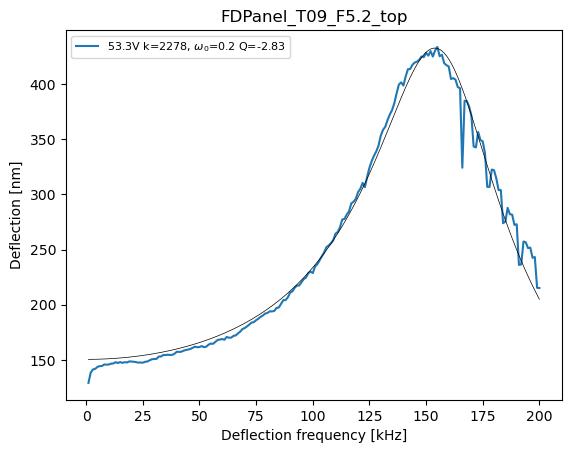

In [73]:

if 1:
    plt.figure()
    actuation_max_voltage = data_dict['actuation_max_voltage']
    # actuation_max_displacement = data_dict['actuation_max_displacement']
    
    
    frequencies = np.array(data_dict['signal_frequencies'])
    amplitude = np.array(data_dict['vibrometer_amplitude'])
    xdata,ydata = frequencies/1e3, amplitude/1e-9
    # fitting
    popt, pcov = curve_fit(fit_amplitude_response, xdata, ydata)
    
    F0,_,w0, Q = popt
    
    new_k = np.power(2*np.pi*w0,2)*mass
    fitdata = fit_amplitude_response(xdata, *popt)
    print(k, new_k)
    print('Calculated: %0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, new_k, w0/1e3, Q))
    
    label = '%0.1fV k=%d, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, k, w0/1e3, Q)
    plt.plot(frequencies/1e3, amplitude/1e-9, label=label)

    plt.plot(xdata, fitdata, c='k', lw=0.5)
    
    if 'device_name' in data_dict.keys():
        title = data_dict['device_name']
        plt.title(title)
        output_figname = data_dict['device_name']+".png"
    plt.xlabel("Deflection frequency [kHz]")
    plt.ylabel("Deflection [nm]")
    plt.legend(fontsize=8)
    output_filefig = os.path.join(output_path, "%s.png"%filename%data_dict['actuation_max_voltage'])
    # plt.savefig(output_filefig, dpi=300)
    data_dict['fit_model_k'] = k
    data_dict['fit_model_f0'] = w0
    data_dict['fit_model_Q'] = Q


### Loading the data

### Amplitude response fit

From Practical MEMS:

(B.11):

$$ |x_0| = \frac{|F_0|/m}{\sqrt{ \left(\omega^2-\omega_0^2\right)^2 +\left(\omega\omega_0/Q\right)^2   }}  = \frac{|F_0|/k}{\sqrt{ \left(1-\frac{\omega^2}{\omega_0^2}\right)^2 +\left(\frac{\omega}{Q\omega_0}\right)^2   }}  $$

['FDPanel_T09_F5.2_top__actuation_18.8V.json', 'FDPanel_T09_F5.2_top__actuation_29.2V.json', 'FDPanel_T09_F5.2_top__actuation_34.2V.json']


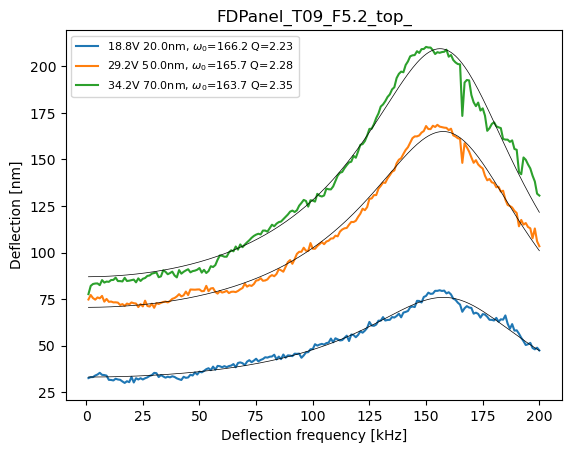

In [13]:

data_path = 'DAQ_outputs//'

file_prefix = "FDPanel_T09_F10.1_bottom"
file_prefix = "FDPanel_T09_F5.2_top"

files = os.listdir(data_path)
files = [d for d in files if ".json" in d]
files = [d for d in files if file_prefix in d]

print(files)
# Loop through existing files
for file in files:
    filename = os.path.join(data_path, file)
    data = open_data_file(filename)

    
    frequencies, amplitude = load_frequency_response(filename)
    actuation_max_voltage = data['actuation_max_voltage']
    actuation_max_displacement = data['actuation_max_displacement']
    
    
    xdata,ydata = frequencies/1e3, amplitude/1e-9
    # fitting
    popt, pcov = curve_fit(fit_amplitude_response, xdata, ydata)
    
    F0,k,w0, Q = popt
    fitdata = fit_amplitude_response(xdata, *popt)

    label = '%0.1fV %0.1fnm'%(actuation_max_voltage, actuation_max_displacement/1e-9)
    label = '%0.1fV %0.1fnm, $\omega_0$=%0.1f Q=%0.2f'%(actuation_max_voltage, actuation_max_displacement/1e-9, w0, Q)
    plt.plot(frequencies/1e3, amplitude/1e-9, label=label)

    plt.plot(xdata, fitdata, c='k', lw=0.5)
    
    if 'device_name' in data.keys():
        title = data['device_name']
        plt.title(title)

plt.xlabel("Deflection frequency [kHz]")
plt.ylabel("Deflection [nm]")
plt.legend(fontsize=8)

# Generate single waveform

press enter to stop.
 


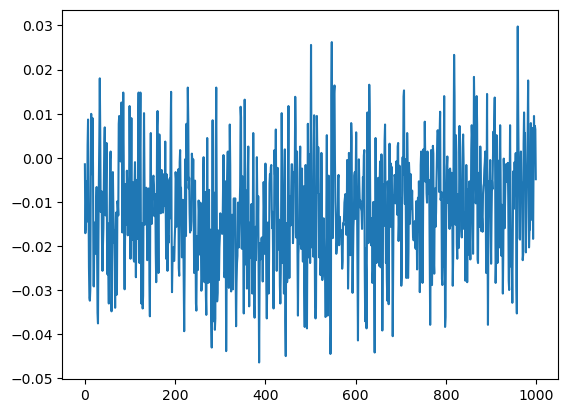

In [34]:
# def set_output_signal(max_displacement, frequency):

frequency = 100e3
max_displacement = 60e-9

fs = 2e6

t_max = 10/frequency

N = int(t_max*fs)
t = np.linspace(0,t_max,N)



data = generate_waveform_signal(t, frequency, max_displacement)

with ni.Task() as read_task, ni.Task() as write_task, ni.Task() as trigger_task:

    # set channels
    # for chan_input, chan_name in zip(data_dict['daq_input_channels'], data_dict['daq_input_channel_names']):
    read_task.ai_channels.add_ai_voltage_chan("Dev1/ai2")

    # for chan_output, chan_name in zip(data_dict['daq_output_channels'], data_dict['daq_output_channel_names']):
    write_task.ao_channels.add_ao_voltage_chan("Dev1/ao0")


    # Set sampling frequency and Continuous output mode to continuously generate the same waveform
    write_task.timing.cfg_samp_clk_timing(fs, sample_mode=ni.constants.AcquisitionType.CONTINUOUS)

    # Set the acquisiton sampling frequency with a finite acquisition
    read_task.timing.cfg_samp_clk_timing(fs, sample_mode=ni.constants.AcquisitionType.FINITE, samps_per_chan=1000)

    # Set the acquisiton trigger to start synchronized with the writing of the waveform
    # write_task.triggers.start_trigger.cfg_dig_edge_start_trig(term_trigger, trigger_edge=ni.constants.Edge.RISING)
    read_task.triggers.start_trigger.cfg_dig_edge_start_trig(write_task.triggers.start_trigger.term, trigger_edge=ni.constants.Edge.FALLING)

#     # set an arbitrary TICKS time after write
    wait_time_after_write = 5000000

    read_task.triggers.start_trigger.delay = wait_time_after_write
    # print(read_task.triggers.start_trigger.delay_units)

    # Write waveform data to output buffer
    write_task.write(data)
    
    # write_task.start()
    
    
#     # Get the actual sample rate and sample interval from the daq
#     sample_clk_rate = read_task.timing.samp_clk_rate
#     dt = 1/sample_clk_rate


#     data_dict['daq_input_sample_rate'] = sample_clk_rate
#     data_dict['daq_input_sample_interval'] = dt
#     # print(sample_clk_rate, dt)

    read_task.start()

    write_task.start()



#     # Read data
    data = read_task.read(number_of_samples_per_channel=ni.constants.READ_ALL_AVAILABLE)


    # while 1:
    #     continue
        
    sec = input('press enter to stop.\n')



#     # set output to 0
#     write_task.stop()
#     write_task.write([0,0])
#     write_task.start()
plt.plot(data)